In [33]:
import logging

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from tqdm import tqdm
import igraph as ig
from ev_station_solver.constants import CONSTANTS
from ev_station_solver.helper_functions import get_distance_matrix
from ev_station_solver.loading import load_locations
from ev_station_solver.logging import get_logger
from ev_station_solver.solving.solver import Solver

import pandas as pd

logger = get_logger(__name__, logging.DEBUG)

# Try to find initial locations, deterministically...

In [12]:
# use given starting solutions
locations = load_locations("medium").sample(1000).values
n_clusters = int(len(locations) * CONSTANTS["mu_charging"] / (2 * CONSTANTS["station_ub"]))
service_level = 0.95

n_clusters = 3 if n_clusters < 3 else n_clusters

In [13]:
# current approach with k means
s = Solver(vehicle_locations=locations, loglevel=logging.INFO, service_level=service_level)

# compute number of initial locations
s.add_initial_locations(n_clusters, mode="k-means", seed=0)
s.add_samples(num=2)

2025-01-13 17:49:52,275 - ev_station_solver.solving.solver - INFO - add_initial_locations: Added 26 k-means locations. Total number of locations: 26.
2025-01-13 17:49:52,280 - ev_station_solver.solving.solver - INFO - add_samples: Added 2 samples.


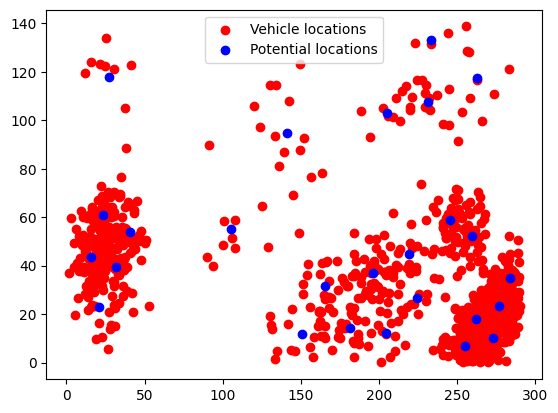

In [14]:
plt.scatter(s.vehicle_locations[:, 0], s.vehicle_locations[:, 1], c="red", label="Vehicle locations")
plt.scatter(s.coordinates_potential_cl[:, 0], s.coordinates_potential_cl[:, 1], c="blue", label="Potential locations")
plt.legend()
plt.show()

# Update Approach
Try to compute a set of initial locations based on the adjacency matrices.

Create a dataframe with the cars across the samples

In [15]:
# create dataframe with all unique locations and the minimum range
locations = np.empty((0, 2))
ranges = np.empty(0)

for sample in s.S:
    # concatenate locations
    locations = np.concatenate((locations, sample.vehicle_locations), axis=0)
    # concatenate ranges
    ranges = np.concatenate((ranges, sample.ranges), axis=0)

In [16]:
# sort locations by range
sorted_indices = np.argsort(ranges)
locations = locations[sorted_indices]
ranges = ranges[sorted_indices]

In [17]:
# drop duplicates (only keep the first occurence with the lowest range)
unique_locations, unique_index = np.unique(locations, axis=0, return_index=True)
# update ranges
unique_ranges = ranges[unique_index]

In [27]:
# get distance matrix
n_locations = len(unique_locations)
distance_matrix = get_distance_matrix(unique_locations, symmetric=True)
total_ranges = unique_ranges[:, np.newaxis] + unique_ranges[np.newaxis, :]
reachibility_matrix = distance_matrix <= total_ranges
reachibility_matrix

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]], shape=(645, 645))

## OR Approach
The idea is to create an optimisation where each clique is added with the number of members. The model should then select the cliques that maximise the reachable cars. One clique is the equivalent to an area that all cars can reach in that qlique.

To achieve this, first all cliques are computed:

In [19]:
# create graph from adjacency matrix
G = ig.Graph.Adjacency(reachibility_matrix.tolist(), mode=ig.ADJ_UNDIRECTED)

In [22]:
# cliques = []

# for k in tqdm(range(reachibility_matrix.shape[0])):
#     # get all cliques of size k
#     cliques_k = G.cliques(min=k, max=k)
#     cliques.extend(cliques_k)

This proved to be infeasible, lets try a different approach.

## New Idea
1. Compute graph
2. compute degress
3. select largest degrees with the smallest range and its neighbours with edges in that subgraph
4. compute maximum clique
5. add ceil nq charing locattions at geometric median with range constraints
6. delete all vertices in maximum clique from main graph
7. repeat from 2

In [39]:
degrees = G.degree(range(n_locations), loops=False)
nodes = pd.DataFrame({"degrees": degrees, "range": unique_ranges})
nodes.index.name = "id"
nodes

,degrees,range
id,,
0,269,150.274804
1,170,77.099598
2,227,124.115810
3,136,26.974744
4,156,53.973813
...,...,...
640,509,132.965446
641,497,105.083266
642,454,50.214119


In [42]:
# sort by degree and then the lowes range
nodes = nodes.sort_values(["degrees", "range"], ascending=[False, True])
nodes

,degrees,range
id,,
156,644,134.918455
174,644,146.643818
172,643,131.668395
214,642,153.611179
233,634,155.984973
...,...,...
8,143,22.710254
81,140,29.608685
3,136,26.974744


In [11]:
def apply_algorithm_step(graph: rw.PyGraph):
    degrees = [(node, G.degree(node)) for node in G.node_indices()]  # get degrees of all nodes
    max_degree_node = max(degrees, key=lambda x: x[1])  # get node with maximum degree

    # get all neighbors of the node with maximum degree
    neighbors = G.neighbors(max_degree_node[0])
    # create a subgrpah with all neighbors and edges between them
    subgraph = G.subgraph(neighbors + [max_degree_node[0]])

    # get the connected components of the subgraph
    connected_components = subgraph.connected_components()

    return max_degree_node

In [12]:
degrees = [(node, G.degree(node)) for node in G.node_indices()]  # get degrees of all nodes
max_degree_node = max(degrees, key=lambda x: x[1])  # get node with maximum degree
max_degree_node

(169, 696)

In [13]:
# get all neighbors of the node with maximum degree
neighbors = G.neighbors(max_degree_node[0])
# create a subgrpah with all neighbors and edges between them
subgraph = G.subgraph(list(neighbors) + [max_degree_node[0]])

In [14]:
def get_max_connected_subgraph(g: rw.PyGraph):
    max_k = len(g.node_indices())

    for k in range(max_k, 0, -1):
        logger.debug(f"Trying to find connected subgraph with {k} nodes")
        connected_subgraphs = rw.connected_subgraphs(g, k)
        if len(connected_subgraphs) > 0:
            return connected_subgraphs[0]

    raise ValueError("No connected subgraph found")

In [ ]:
# get_max_connected_subgraph(subgraph)

In [12]:
import igraph as ig

In [13]:
G_ig = ig.Graph.Adjacency((reachibility_matrix > 0).tolist())

In [14]:
G_ig.maximal_cliques()

2025-01-13 17:36:38,608 - py.warnings - WARNING - _showwarnmsg: /var/folders/_8/v4jd3c2n5lq0425b8tsn0v2h0000gp/T/ipykernel_33493/3442476505.py:1: RuntimeWarning: Edge directions are ignored for maximal clique calculation at src/cliques/maximal_cliques.c:220
  G_ig.maximal_cliques()



[(166,
  28,
  588,
  585,
  571,
  525,
  521,
  467,
  425,
  422,
  399,
  359,
  334,
  329,
  313,
  298,
  296,
  283,
  280,
  279,
  276,
  275,
  273,
  269,
  266,
  265,
  264,
  248,
  242,
  240,
  239,
  233,
  229,
  228,
  224,
  220,
  218,
  215,
  214,
  213,
  212,
  211,
  206,
  205,
  204,
  203,
  201,
  199,
  197,
  195,
  193,
  192,
  189,
  187,
  186,
  184,
  183,
  181,
  180,
  178,
  176,
  174,
  173,
  172,
  170,
  169,
  168,
  164,
  163,
  161,
  159,
  157,
  156,
  155,
  154,
  152,
  151,
  125,
  122,
  79,
  78,
  68,
  63,
  51,
  133,
  150,
  40,
  108,
  121,
  5,
  136,
  98,
  81,
  60,
  7),
 (166,
  28,
  588,
  585,
  571,
  525,
  521,
  467,
  425,
  422,
  399,
  359,
  334,
  329,
  313,
  298,
  296,
  283,
  280,
  279,
  276,
  275,
  273,
  269,
  266,
  265,
  264,
  248,
  242,
  240,
  239,
  233,
  229,
  228,
  224,
  220,
  218,
  215,
  214,
  213,
  212,
  211,
  206,
  205,
  204,
  203,
  201,
  199,
  197,
  195,

In [16]:
G_ig.largest_cliques()

2025-01-13 17:37:34,283 - py.warnings - WARNING - _showwarnmsg: /var/folders/_8/v4jd3c2n5lq0425b8tsn0v2h0000gp/T/ipykernel_33493/1947278058.py:1: RuntimeWarning: Edge directions are ignored for maximal clique calculation at src/cliques/maximal_cliques.c:220
  G_ig.largest_cliques()



[(447,
  154,
  682,
  680,
  678,
  677,
  676,
  674,
  673,
  672,
  671,
  670,
  669,
  667,
  666,
  665,
  664,
  663,
  662,
  660,
  659,
  657,
  656,
  655,
  653,
  651,
  650,
  649,
  648,
  647,
  646,
  645,
  644,
  642,
  641,
  640,
  639,
  637,
  636,
  635,
  634,
  633,
  632,
  629,
  628,
  627,
  626,
  625,
  624,
  622,
  621,
  620,
  619,
  618,
  617,
  616,
  615,
  614,
  613,
  612,
  611,
  610,
  609,
  608,
  607,
  606,
  605,
  603,
  602,
  600,
  599,
  598,
  597,
  596,
  595,
  594,
  592,
  591,
  590,
  589,
  588,
  587,
  586,
  585,
  584,
  583,
  582,
  581,
  580,
  579,
  578,
  577,
  576,
  575,
  574,
  573,
  572,
  571,
  570,
  569,
  568,
  567,
  566,
  565,
  564,
  563,
  562,
  560,
  559,
  558,
  557,
  556,
  552,
  551,
  550,
  549,
  548,
  547,
  546,
  545,
  544,
  543,
  542,
  541,
  540,
  539,
  538,
  537,
  536,
  535,
  534,
  532,
  531,
  530,
  529,
  528,
  527,
  526,
  525,
  524,
  523,
  521,
  520,

In [30]:
apply_algorithm_step(G)

(208, 658)

In [26]:
[(node, G.degree(node)) for node in G.node_indices()]

[(0, 231),
 (1, 178),
 (2, 178),
 (3, 248),
 (4, 174),
 (5, 158),
 (6, 161),
 (7, 170),
 (8, 158),
 (9, 177),
 (10, 276),
 (11, 168),
 (12, 178),
 (13, 179),
 (14, 166),
 (15, 197),
 (16, 181),
 (17, 174),
 (18, 172),
 (19, 182),
 (20, 160),
 (21, 171),
 (22, 188),
 (23, 190),
 (24, 186),
 (25, 177),
 (26, 172),
 (27, 164),
 (28, 191),
 (29, 243),
 (30, 192),
 (31, 169),
 (32, 179),
 (33, 174),
 (34, 223),
 (35, 236),
 (36, 175),
 (37, 195),
 (38, 191),
 (39, 177),
 (40, 173),
 (41, 181),
 (42, 256),
 (43, 196),
 (44, 194),
 (45, 224),
 (46, 246),
 (47, 213),
 (48, 259),
 (49, 217),
 (50, 167),
 (51, 178),
 (52, 166),
 (53, 192),
 (54, 164),
 (55, 245),
 (56, 170),
 (57, 207),
 (58, 195),
 (59, 176),
 (60, 191),
 (61, 196),
 (62, 174),
 (63, 200),
 (64, 250),
 (65, 160),
 (66, 289),
 (67, 207),
 (68, 175),
 (69, 169),
 (70, 174),
 (71, 173),
 (72, 146),
 (73, 180),
 (74, 176),
 (75, 212),
 (76, 243),
 (77, 260),
 (78, 192),
 (79, 192),
 (80, 237),
 (81, 206),
 (82, 163),
 (83, 175),
 (

In [41]:
results = []
for i, k in enumerate(tqdm(range(len(unique_locations))[::-1])):
    results.append(rw.connected_subgraphs(G, k=k))

    if i == 1:
        break

: 

: 

In [16]:
k

26

In [15]:
results

[[[5,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
   7,
   25,
   17,
   11,
   3,
   28,
   12,
   1,
   18,
   4,
   8,
   0,
   21,
   23,
   10,
   16,
   26,
   19,
   24],
  [5,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
   25,
   17,
   11,
   3,
   28,
   12,
   1,
   9,
   18,
   4,
   8,
   0,
   21,
   23,
   10,
   16,
   26,
   19,
   24],
  [7,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
   25,
   17,
   11,
   3,
   28,
   12,
   1,
   9,
   18,
   4,
   8,
   0,
   21,
   23,
   10,
   16,
   26,
   19,
   24],
  [7,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
   25,
   17,
   11,
   3,
   28,
   12,
   1,
   9,
   18,
   4,
   8,
   0,
   21,
   23,
   10,
   16,
   26,
   19,
   5],
  [7,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
   25,
   17,
   11,
   3,
   28,
   12,
   1,
   9,
   18,
   4,
   8,
   0,
   21,
   23,
   10,
   24,
   26,
   19,
   5],
  [7,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
  

In [14]:
for k in tqdm(range(len(unique_locations))):
    rw.connected_subgraphs(G, k=k)

 14%|█▍        | 5/35 [00:24<00:00, 35.34it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1046d2e60>>
Traceback (most recent call last):
  File "/Users/justuswolff_private/Repositories/ev-station-solver/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


: 

: 

In [13]:
unique_locations

array([[  4.93,  39.61],
       [ 13.33,  44.23],
       [ 16.34,  63.31],
       [ 26.72,   5.68],
       [ 27.24,  54.37],
       [ 29.65,  33.47],
       [ 45.14,  66.55],
       [106.17,  51.6 ],
       [125.22,  64.62],
       [134.97,   4.67],
       [173.74,  10.72],
       [199.85,  26.26],
       [202.02,  13.11],
       [203.09,  42.6 ],
       [208.82,  36.83],
       [218.19,  39.01],
       [219.83, 104.17],
       [248.48,  60.21],
       [250.99,  62.22],
       [251.09,   8.78],
       [252.23,  11.12],
       [255.89,  64.94],
       [258.31,  43.73],
       [263.99,  10.3 ],
       [264.82,   4.85],
       [266.15,  25.19],
       [267.98,  14.93],
       [270.53,  19.95],
       [270.66,  27.32],
       [271.28,  22.57],
       [273.29,  27.93],
       [273.32, 110.71],
       [281.97,  24.86],
       [283.63,  23.29],
       [284.62,  20.71]])